# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
pip install missingno

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import lightgbm as lgb
import missingno as msno
from IPython.display import display
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler 
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [3]:
warnings.filterwarnings("ignore")

In [41]:
data=pd.read_csv('/datasets/autos.csv')
display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
def fun_date(data):
    print('**Общая информация датафрейма**')
    print(data.info())
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Просмотр статистических данных**')
    print(data.describe())
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Вывод рандомных строк датафрейма**')
    print(data.sample(n=3, random_state=1))
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Вывод первых пяти строк датафрейма**')
    print(data.head())
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Вывод количесва дубликатов датафрейма**')
    print(data.duplicated().sum())
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Вывод количесва пропущеных значений датафрейма**')
    print(data.isnull().sum())
    #print(msno.heatmap(data))
    print('-------------------------------------------------------------------------------------------------------------')
print(fun_date(data))

**Общая информация датафрейма**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
None
--------------------------------------------------------------------------------------------------------

In [6]:
data.drop_duplicates().reset_index(drop= True).head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [7]:
data['NotRepaired'].value_counts()
data['NotRepaired'] = data['NotRepaired'].fillna('no')

In [8]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%dT%H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%dT%H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%dT%H:%M:%S')


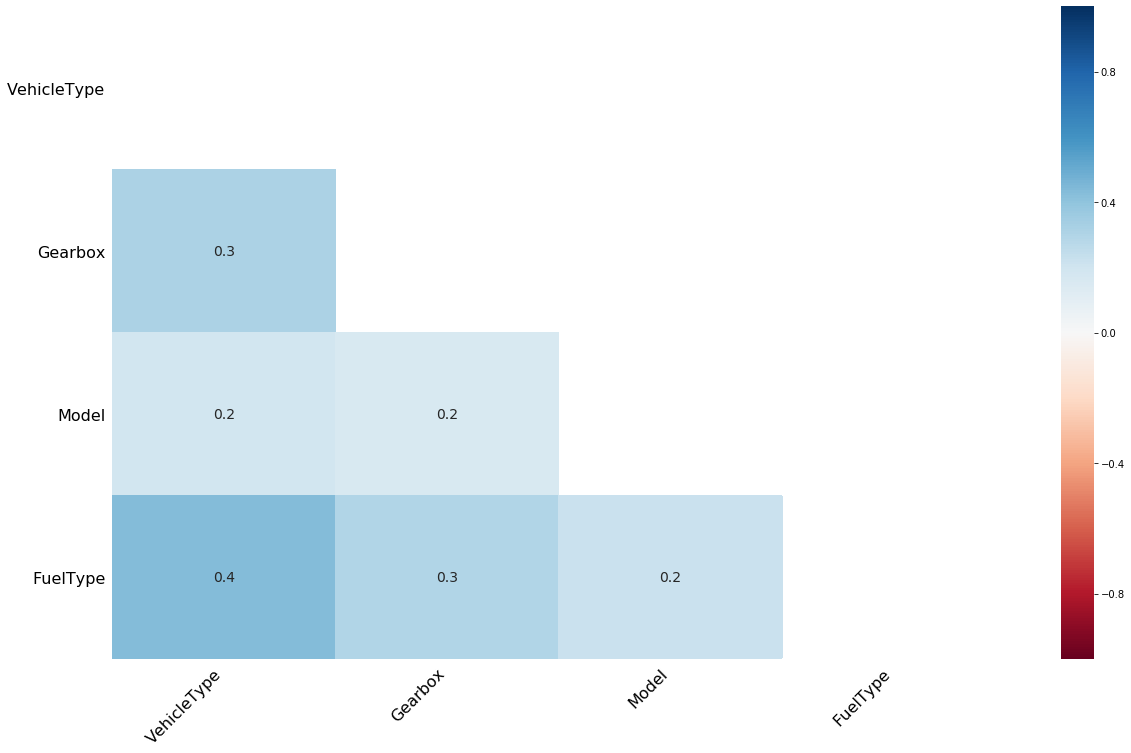

In [9]:
msno.heatmap(data)

In [10]:
#filtered_data = msno.nullity_filter(data, filter='bottom', n=15, p=0.999) # or filter='top'
#msno.matrix(filtered_data.sample(250))

In [11]:
#data['VehicleType'] = data['VehicleType'].fillna('unknown')
#data['Gearbox'] = data['Gearbox'].fillna('unknown')
#data['FuelType'] = data['FuelType'].fillna('unknown')
#data['Model'] = data['Model'].fillna('unknown')

In [12]:
print('Количесво строк до удаления пропусков:',data.shape[0])

Количесво строк до удаления пропусков: 354369


In [13]:
data.dropna(subset=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired'], inplace=True)

In [14]:
print('Количесво строк после удаления пропусков:',data.shape[0])

Количесво строк после удаления пропусков: 284126



Удалено 70243 строки - почти 20%


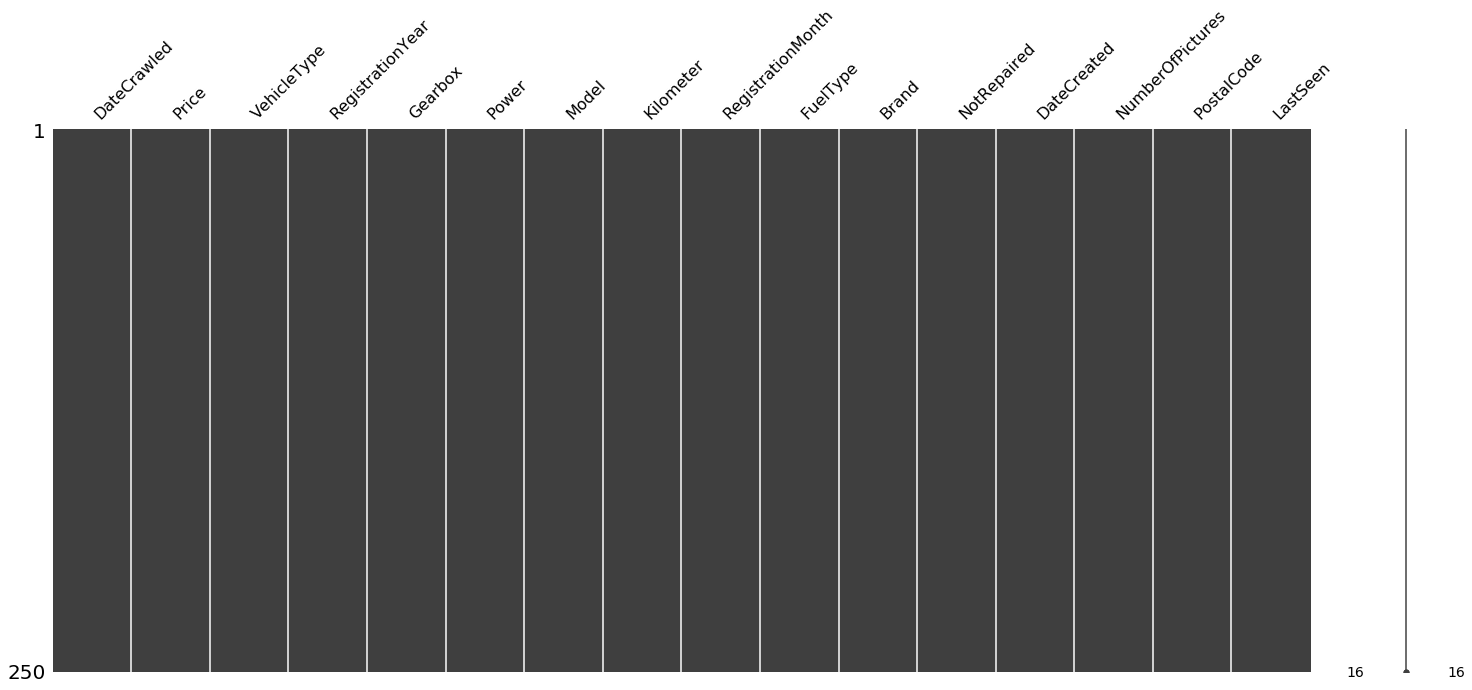

In [15]:
sorted_data = msno.nullity_sort(data, sort='descending') # or sort='ascending'
msno.matrix(sorted_data.sample(250))

Text(0, 0.5, 'count')

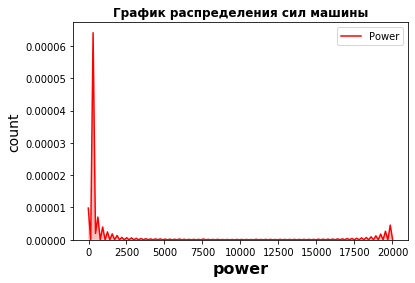

In [16]:
plt.title('График распределения сил машины', fontweight='bold')
fig = sns.kdeplot(data['Power'],color='r', legend=True,shade=True)
plt.xlabel('power', fontweight='bold', fontsize=16)
plt.ylabel('count', fontweight='light', fontsize=14)

Text(0, 0.5, 'count')

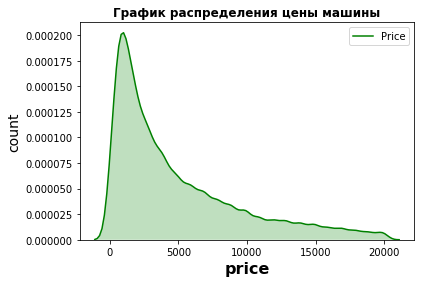

In [17]:
plt.title('График распределения цены машины', fontweight='bold')
fig = sns.kdeplot(data['Price'],color='g', legend=True,shade=True)
plt.xlabel('price', fontweight='bold', fontsize=16)
plt.ylabel('count', fontweight='light', fontsize=14)

Text(0, 0.5, 'count')

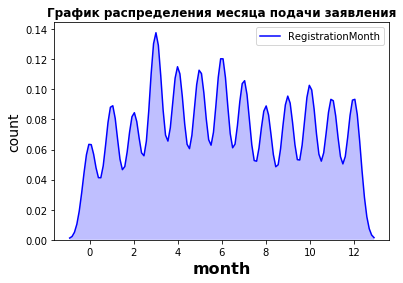

In [18]:
plt.title('График распределения месяца подачи заявления', fontweight='bold')
fig = sns.kdeplot(data['RegistrationMonth'],color='b', legend=True,shade=True)
plt.xlabel('month', fontweight='bold', fontsize=16)
plt.ylabel('count', fontweight='light', fontsize=14)

<font color='blue'>Заменты аномалии в нулевых значениях!

In [19]:
data=data.query('Power > 50  & Price > 1000 & RegistrationMonth>1')


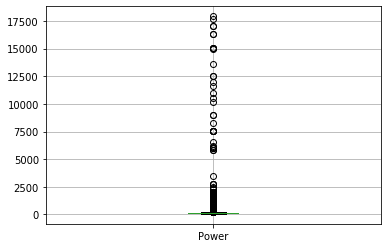

In [20]:
data.boxplot('Power')

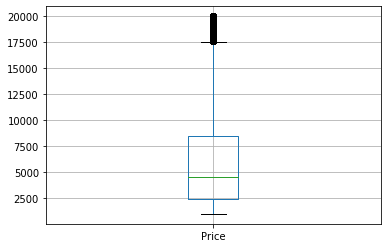

In [21]:
data.boxplot('Price')

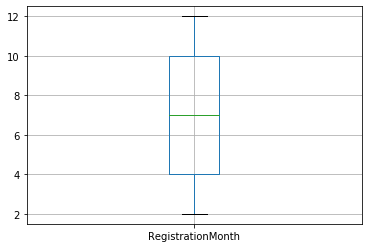

In [22]:
data.boxplot('RegistrationMonth')

<font color='blue'>Уменьшили разброс данных. Если уменьшать их еще больше, то данных совсем не останется с учетом удаления пропусков.У меня удалось полностью убрать выбросы, но дамми перестают работать...кошмар какой-то(: Поэтому так ¯\_(ツ)_/¯

<div class="alert alert-info"> 
<b>Сделии предобработку данных:</b>
    
- перевели столбец с датой в нужный формат. 

- имеются дубликаты- от них избавляемся.
    
- заполнили пропуски в колонке 'NotRepaired' на 'no', предполагая, что машина не была в ремонте;
    
- избавились от аномальных значений;
</div>


<div class="alert alert-info"> 
Колонки VehicleType,Gearbox,FuelType,Model имеют много пропусков, но судя по метрике их по сути не так уж и много, все входят в диапозон до 0.5(или 10%) - можно удалять и не жалеть.
</div>

<div class="alert alert-info"> 
Изначально я заменил все пропуски на 'unknown', но изза этого я не смог перевести категорийные данные в дамми...очень много способов перепробовал. Единсвенное подошло закинуть весь датафрейм в дамми, но потом не смог обучать модель.
    
    Что имею по итогу, удалил пропуски - смог перекинуть все, что хотел в дамми и плюс ко всему увеличилась точность моделей.
</div>

## Обучение моделей

In [23]:
#data=pd.get_dummies(data)


In [24]:
d_ohe=pd.get_dummies(data['VehicleType'])
d_ohe1=pd.get_dummies(data['Gearbox'])
d_ohe2=pd.get_dummies(data['Brand'])
d_ohe3=pd.get_dummies(data['NotRepaired'])
d_ohe4=pd.get_dummies(data['FuelType'])
df1=d_ohe.join(d_ohe1.drop('auto', axis=1)).join(d_ohe2).join(d_ohe4.drop('other', axis=1))
df1['Repaired']=d_ohe3['no']
df1['DateCrawled']=data['DateCrawled']
df2=data.merge(df1, on='DateCrawled')

<font color='blue'>Перевели категорийные данные в дамми 

In [25]:
df2.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,...,trabant,volkswagen,volvo,cng,electric,gasoline,hybrid,lpg,petrol,Repaired
0,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,...,0,0,0,0,0,1,0,0,0,1
1,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,...,0,1,0,0,0,0,0,0,1,1
2,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,...,0,0,0,0,0,1,0,0,0,1


In [26]:
data_train, data_test = train_test_split(df2, test_size=0.25, random_state=12345)
train_features=data_train.drop(['DateCreated', 'Price', 'FuelType', 'RegistrationMonth', 'LastSeen', 'VehicleType', 'PostalCode', 'Brand', 'NotRepaired', 'Gearbox',  'Model', 'DateCrawled'], axis=1)
train_target=data_train['Price']
test_features=data_test.drop(['Price', 'DateCreated', 'FuelType', 'RegistrationMonth', 'LastSeen', 'VehicleType', 'PostalCode', 'Brand', 'NotRepaired', 'Gearbox',  'Model', 'DateCrawled'], axis=1)
test_target=data_test['Price']
scaler = StandardScaler()
scaler.fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)
print(len(data_train))
print(len(data_test))

186809
62270


<font color='blue'>Разбили данные на таргеты и фичи 

In [27]:
def hq (model):
    test_predict=model.predict(test_features)
    mse=mean_squared_error(test_target, test_predict)
    rmse=mse**0.5
    print("Точность модели", model.score(test_features, test_target))
    print('RMSE модели:', rmse)

In [28]:
model_lr = LinearRegression(copy_X=True, fit_intercept=True, normalize=True)
model_lr.fit(train_features, train_target)
print('intercept:', model_lr.intercept_)
print('slope:', model_lr.coef_)
print(hq(model_lr))

intercept: 6118.495870827377
slope: [ 1.95095311e+03  4.47160761e+02 -1.37552034e+03  2.56750771e+18
  1.34371404e+16  1.15834072e+16  9.71718811e+15  3.52286384e+15
  1.99893814e+16  1.72058360e+16  9.07666525e+15  1.79663501e+16
 -4.74107750e+02  4.64655694e+15  1.70654484e+16  1.87608379e+16
  4.28197961e+15  3.60454253e+15  6.74815354e+15  3.39042054e+15
  1.67048598e+15  2.12227356e+15  8.22726664e+15  1.36765032e+16
  4.95292537e+15  6.19751175e+15  2.53438389e+15  2.78131815e+15
  5.12071779e+15  1.35564760e+15  1.63908972e+15  2.52071146e+15
  7.00158050e+15  1.76753308e+16  6.59522753e+15  4.64471492e+15
  6.41874363e+15  1.64414890e+16  9.89925793e+15  2.97615906e+15
  1.09284362e+16  1.43632340e+15  2.26803547e+15  7.72734739e+15
  8.16850065e+15  6.43189443e+15  2.40492628e+15  4.66676994e+15
  7.22240743e+15  2.29552537e-02  2.32444538e+16  5.44499162e+15
  1.46945414e+01  1.00332227e+01  6.37258296e+02  5.69468971e+01
  2.79790465e+01  2.35031684e+02  3.49070082e+02]
Точн

In [29]:
%%time
model_lr = LinearRegression()
model_lr.fit(train_features, train_target)

CPU times: user 1.88 s, sys: 555 ms, total: 2.44 s
Wall time: 2.49 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
%%time
print('Линейная регрессия')
print()
print(hq(model_lr))
print()

Линейная регрессия

Точность модели -6.910663230813366e+17
RMSE модели: 3849592097019.406
None

CPU times: user 59.6 ms, sys: 52.6 ms, total: 112 ms
Wall time: 100 ms


In [31]:
%%time
model_cat=CatBoostRegressor(iterations=15,learning_rate=1,depth=5, random_seed=12345)
model_cat.fit(train_features, train_target)

0:	learn: 2825.5555823	total: 138ms	remaining: 1.93s
1:	learn: 2585.4945389	total: 236ms	remaining: 1.54s
2:	learn: 2466.9560602	total: 247ms	remaining: 988ms
3:	learn: 2418.4513811	total: 345ms	remaining: 948ms
4:	learn: 2338.1948457	total: 442ms	remaining: 883ms
5:	learn: 2292.1691390	total: 542ms	remaining: 812ms
6:	learn: 2261.8727878	total: 639ms	remaining: 730ms
7:	learn: 2228.1128527	total: 738ms	remaining: 646ms
8:	learn: 2202.4730236	total: 836ms	remaining: 557ms
9:	learn: 2181.4764164	total: 936ms	remaining: 468ms
10:	learn: 2168.1564160	total: 1.03s	remaining: 376ms
11:	learn: 2155.2326487	total: 1.13s	remaining: 283ms
12:	learn: 2142.6708735	total: 1.23s	remaining: 189ms
13:	learn: 2134.3019317	total: 1.33s	remaining: 94.9ms
14:	learn: 2128.3556081	total: 1.34s	remaining: 0us
CPU times: user 1.98 s, sys: 317 ms, total: 2.3 s
Wall time: 3.38 s


In [32]:
%%time
print()
print('CatBoost')
print()
print(hq(model_cat))
print()


CatBoost

Точность модели 0.7881791813639059
RMSE модели: 2131.273428252577
None

CPU times: user 38.7 ms, sys: 5.88 ms, total: 44.6 ms
Wall time: 31.1 ms


In [33]:
%%time
model_sgd = SGDRegressor(alpha= 0.5, max_iter = len(data), random_state=12345)
model_sgd.fit(train_features, train_target)

CPU times: user 1.41 s, sys: 7.78 ms, total: 1.42 s
Wall time: 1.43 s


SGDRegressor(alpha=0.5, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=193581,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=12345,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [34]:
%%time
print('SGD')
print()
print(hq(model_sgd))
print()

SGD

Точность модели 0.44420115132965104
RMSE модели: 3452.340878764941
None

CPU times: user 54.4 ms, sys: 44.8 ms, total: 99.3 ms
Wall time: 45.2 ms


In [35]:
%%time
model_LGBM = lgb.LGBMRegressor(n_estimators=100, max_depth=5, boosting_type = 'gbdt', random_state=12345)
model_LGBM.fit(train_features, train_target)

CPU times: user 9.57 s, sys: 74.9 ms, total: 9.65 s
Wall time: 9.8 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [36]:
%%time
print()
print('LGBM')
print()
print(hq(model_LGBM))
print()


LGBM

Точность модели 0.8168605647634335
RMSE модели: 1981.73593525288
None

CPU times: user 870 ms, sys: 22 ms, total: 892 ms
Wall time: 891 ms


In [37]:
from sklearn.metrics import make_scorer
train_features=data_train.drop(['DateCreated', 'Price', 'FuelType', 'RegistrationMonth', 'LastSeen', 'VehicleType', 'PostalCode', 'Brand', 'NotRepaired', 'Gearbox',  'Model', 'DateCrawled'], axis=1)
train_target=data_train['Price']
def lr_gridsearchcv(features, target):
    model_lr = LinearRegression()
    param_grid = {
        'copy_X':[True, False],
        'fit_intercept' : [True, False],
        'normalize':[True,False]
    }
    
    
    
    CV = GridSearchCV(estimator = model_lr, param_grid = param_grid, cv=5)
    CV.fit(features, target)
    print('Лучшие гиперпараметры: ', CV.best_params_)
    return CV.best_params_ 

lr_gridsearchcv(train_features, train_target)

Лучшие гиперпараметры:  {'copy_X': True, 'fit_intercept': False, 'normalize': True}


{'copy_X': True, 'fit_intercept': False, 'normalize': True}

<font color='blue'>Определил лучшие гиперпараметры для линейной регрессии

In [38]:
data_train, data_test = train_test_split(df2, test_size=0.25, random_state=12345)
print(len(data_train))
print(len(data_test))
train_features=data_train.drop(['DateCreated', 'Price',  'RegistrationMonth', 'LastSeen',  'PostalCode', 'Brand',  'Model', 'DateCrawled'], axis=1)
train_target=data_train['Price']
test_features=data_test.drop(['DateCreated', 'Price',  'RegistrationMonth', 'LastSeen',  'PostalCode', 'Brand',  'Model', 'DateCrawled'], axis=1)
test_target=data_test['Price']
category=['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']
train_features[category] = train_features[category].astype('category')
test_features[category] = test_features[category].astype('category')

186809
62270


In [39]:
model_cat=CatBoostRegressor(iterations=15,
                          learning_rate=1,
                          depth=5, random_seed=12345, cat_features = category)
model_cat.fit(train_features, train_target)
hq(model_cat)

0:	learn: 2818.4955062	total: 65.6ms	remaining: 918ms
1:	learn: 2573.5099607	total: 252ms	remaining: 1.64s
2:	learn: 2442.8164410	total: 356ms	remaining: 1.42s
3:	learn: 2378.0971600	total: 547ms	remaining: 1.5s
4:	learn: 2303.5142244	total: 655ms	remaining: 1.31s
5:	learn: 2260.8451267	total: 846ms	remaining: 1.27s
6:	learn: 2214.0379140	total: 950ms	remaining: 1.08s
7:	learn: 2185.8275875	total: 1.05s	remaining: 921ms
8:	learn: 2150.1353984	total: 1.25s	remaining: 831ms
9:	learn: 2132.3161938	total: 1.36s	remaining: 678ms
10:	learn: 2118.7394476	total: 1.54s	remaining: 562ms
11:	learn: 2103.6119438	total: 1.65s	remaining: 413ms
12:	learn: 2089.3819386	total: 1.84s	remaining: 283ms
13:	learn: 2072.6873429	total: 1.95s	remaining: 139ms
14:	learn: 2058.5449413	total: 2.14s	remaining: 0us
Точность модели 0.8015140443227042
RMSE модели: 2063.0974423767752


In [40]:
model_gbm = lgb.LGBMRegressor(n_estimators=100, max_depth=5, boosting_type = 'gbdt', random_state=12345, 
                              cat_features = category)
model_gbm.fit(train_features, train_target)
hq(model_gbm)

Точность модели 0.831589565172024
RMSE модели: 1900.3751724043846


## Анализ моделей

<div class="alert alert-info"> 
Что можно сказать по поводу всего этого. Очень не понятен мне момент с линейной регрессией, ведет себя очень хаотично, улучшил точность до 0.44, как только стал избавляться от выбросов - откатила аж меньше нуля, не будем ее использовать.

Лучше всех себя показала модель CatBoostRegressor со временем cpu = 1.88, точностью = 0.78 и rmse=2131

SGD оказался среднячком с плюс/минус таким же временем как у cat, но страдает точность - 0.44

Ну и наш аутсайдер по времени  - это LGBM, его время обработки составило более 2х минут, и это не предел, бывало до 5 минут доходило. Но зато лучшая точность, тут уже нужно выбирать, что мы хотим точность и быстродействие!
<\div> 

<div class="alert alert-info"> 
После преобразований в категории Cat по прежнему остается лучшим!
